#1. Data Loading

In [ ]:
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')
# file path
file_path = "/content/drive/MyDrive/device_final_four.txt"

# reading the data
data = pd.read_csv(file_path, delimiter='|', encoding='latin1', on_bad_lines='skip')

# displaying first few rows of the data frame
data.head()

Mounted at /content/drive


,MDR_REPORT_KEY,DEVICE_EVENT_KEY,IMPLANT_FLAG,DATE_REMOVED_FLAG,DEVICE_SEQUENCE_NO,DATE_RECEIVED,BRAND_NAME,GENERIC_NAME,MANUFACTURER_D_NAME,MANUFACTURER_D_ADDRESS_1,...,DEVICE_AGE_TEXT,DEVICE_EVALUATED_BY_MANUFACTUR,COMBINATION_PRODUCT_FLAG,UDI.DI,UDI.PUBLIC,MDR_TEXT_KEY,TEXT_TYPE_CODE,PATIENT_SEQUENCE_NUMBER,DATE_REPORT,FOI_TEXT
0,9539789,NaN,NaN,NaN,1,2020/01/02,HIRES 90K,COCHLEAR IMPLANT,"ADVANCED BIONICS, LLC",28515 WESTINGHOUSE PLACE,...,DA,NaN,N,7.630017e+12,(01)07630016828638(11)141108(17)170930,178124779,D,1,NaN,THE RECIPIENT REPORTEDLY EXPERIENCED A DISPLAC...
1,9539789,NaN,NaN,NaN,1,2020/01/02,HIRES 90K,COCHLEAR IMPLANT,"ADVANCED BIONICS, LLC",28515 WESTINGHOUSE PLACE,...,DA,NaN,N,7.630017e+12,(01)07630016828638(11)141108(17)170930,315216561,N,0,NaN,ADVANCED BIONICS CONSIDERS THE INVESTIGATION I...
2,9540970,NaN,NaN,NaN,1,2020/01/02,CLARION,COCHLEAR IMPLANT,"ADVANCED BIONICS, LLC",28515 WESTINGHOUSE PLACE,...,DA,NaN,N,NaN,NaN,178020922,D,1,NaN,THE RECIPIENT REPORTEDLY ELECTED EXPLANT SURGE...
3,9540970,NaN,NaN,NaN,1,2020/01/02,CLARION,COCHLEAR IMPLANT,"ADVANCED BIONICS, LLC",28515 WESTINGHOUSE PLACE,...,DA,NaN,N,NaN,NaN,315369026,N,0,NaN,ADVANCED BIONICS CONSIDERS THE INVESTIGATION I...
4,9540970,NaN,NaN,NaN,1,2020/01/02,CLARION,COCHLEAR IMPLANT,"ADVANCED BIONICS, LLC",28515 WESTINGHOUSE PLACE,...,DA,NaN,N,NaN,NaN,315399750,N,0,NaN,THE RECIPIENT'S ISSUES RESOLVED. DISCLAIMER: A...


In [ ]:
# checking for missing values in the important columns
missing_values = data[['MDR_REPORT_KEY', 'DATE_RECEIVED', 'FOI_TEXT']].isna().sum()

print("Missing values in each column:")
print(missing_values)

Missing values in each column:
MDR_REPORT_KEY    0
DATE_RECEIVED     0
FOI_TEXT          0
dtype: int64


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47184 entries, 0 to 47183
Data columns (total 36 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   MDR_REPORT_KEY                  47184 non-null  int64  
 1   DEVICE_EVENT_KEY                0 non-null      float64
 2   IMPLANT_FLAG                    0 non-null      float64
 3   DATE_REMOVED_FLAG               0 non-null      float64
 4   DEVICE_SEQUENCE_NO              47184 non-null  int64  
 5   DATE_RECEIVED                   47184 non-null  object 
 6   BRAND_NAME                      47179 non-null  object 
 7   GENERIC_NAME                    47184 non-null  object 
 8   MANUFACTURER_D_NAME             47044 non-null  object 
 9   MANUFACTURER_D_ADDRESS_1        30409 non-null  object 
 10  MANUFACTURER_D_ADDRESS_2        0 non-null      float64
 11  MANUFACTURER_D_CITY             47043 non-null  object 
 12  MANUFACTURER_D_STATE_CODE       

In [ ]:
# checking for duplicate values in the MDR_TEXT_KEY column
duplicate_values = data[data.duplicated(subset='MDR_TEXT_KEY', keep=False)]
print(f"Number of duplicate values in 'MDR_TEXT_KEY': {duplicate_values.shape[0]}")


Number of duplicate values in 'MDR_TEXT_KEY': 0


In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# 2. Data Preprocessing

In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

#  lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# preprocessing function
def preprocess_text(text):
    # lowercase the text
    text = text.lower()

    # remove special characters, symbols, and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # tokenize text
    words = word_tokenize(text)

    # lemmatize and remove stopwords
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and len(word) > 1]

    # return preprocessed text as a single string
    return ' '.join(words)

# applying preprocessing to FOI_TEXT column
data['processed_text'] = data['FOI_TEXT'].apply(preprocess_text)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


#3. Adverse Event Identification

In [ ]:
import pandas as pd
import re

# dictionary for adverse events and their corresponding keywords
adverse_events_keywords = {
    "Pain": [
        "hurt", "pain", "ear pain", "headache", "discomfort",
        "intense pain", "severe pain", "earache", "throbbing pain"
    ],
    "Device Problem": [
        "device malfunction", "broken electrode","electrode severed",
        "device failure", "implant failure", "defective device",
        "electrode extrusion", "electrode migration", "device migration",
         "device misplacement", "device rejection", "severed electrode", "electrode broken",
"open electrode",
"broken electrode wire",
"device moisture",
"electrode tip foldover",
"silicone damage",
"decreased performance",
"decline hearing performance",
"device failed",
 "intermittent sound quality",
"mechanical damage",
"decreased hearing performance",
"overly loud sound",
"damage active electrode","displaced magnet","electrode array tip fold",
"electrode migrated",
"device extrusion"

    ],
    "Infections": [
        "otitis media", "external ear infection", "skin infection",
        "flap infection", "middle ear infection", "meningitis",
        "infected", "infectious", "ear discharge",
        "mastoiditis", "cellulitis", "infection"
    ],
    "Balance Issues": [
        "dizziness", "vertigo", "loss of balance", "balance problems",
        "instability", "light headedness", "spinning sensation", "unsteadiness",
        "balance disorder"
    ],
    "Hearing Loss or Dysfunction": [
        "loss of hearing", "hearing impairment", "worsening hearing",
        "sound distortion", "hearing drop", "diminished hearing",
        "tinnitus", "ringing in the ears", "muffled hearing", "buzzing"
    ],
    "Swelling": [
        "swelling", "swollen", "bulge", "redness", "inflamed",
        "puffiness", "swelling at implant site", "ear swelling", "flap swelling","edema"
    ],
    "Numbness": [
        "numbness", "loss of sensation", "tingling", "facial numbness",
        "loss of feeling", "nerve damage", "sensory loss"
    ],
    "Headaches": [
        "headache", "migraines", "intense head pain", "throbbing headache",
        "pressure", "cranial discomfort"
    ],
    "Tinnitus": [
        "ringing in the ears", "buzzing", "noise perception",
        "ear ringing", "humming", "persistent sound in ears"
    ],
    "Facial Palsy": [
        "facial paralysis", "facial weakness", "facial palsy",
        "loss of facial movement", "drooping face", "facial nerve damage",
        "lack of muscle control", "facial never paralysis"
    ],
    "Infection Recurrence": [
        "recurring infection", "infection relapse", "repeated infections",
        "recurrent otitis media", "persistent infection", "recurring mastoiditis"
    ],
    "Adverse Reactions": [
        "allergic reaction", "skin rash", "hives", "itching",
        "redness", "irritation", "sensitivity to implant material",
        "allergic dermatitis"
    ],
    "Nausea/Vomiting": [
        "nausea", "vomiting", "queasiness", "upset stomach",
        "dizziness related nausea", "puke", "throw up"
    ],
    "Inflammation": [
        "chronic inflammation", "persistent inflammation",
        "prolonged swelling", "chronic infection", "ongoing inflammatory response", "inflammation"
    ],
    "Ear Discharge": [
        "ear drainage", "ear discharge", "otorrhea", "fluid from the ear",
        "pus from the ear", "leakage from ear"
    ],
    "Death": [
        "death", "deceased", "expired", "passed away", "fatal outcome",
        "demise"
    ],
    "Trauma": [
        "trauma", "head trauma"
    ]
}

# function to identify adverse events
def identify_adverse_events(text):
    identified_events = []
    for event, keywords in adverse_events_keywords.items():
        # checking if any keyword is present in the text
        for keyword in keywords:
            if re.search(r'\b' + re.escape(keyword) + r'\b', text):
                identified_events.append(event)
                break  # stop checking keywords if one is found
    return identified_events

# applying the function to the processed_text column
data['identified_events'] = data['processed_text'].apply(identify_adverse_events)

# display the updated DataFrame with identified events
data[['FOI_TEXT', 'processed_text', 'identified_events']].head()

,FOI_TEXT,processed_text,identified_events
0,THE RECIPIENT REPORTEDLY EXPERIENCED A DISPLAC...,recipient reportedly experienced displaced mag...,[Device Problem]
1,ADVANCED BIONICS CONSIDERS THE INVESTIGATION I...,advanced bionics considers investigation repor...,[]
2,THE RECIPIENT REPORTEDLY ELECTED EXPLANT SURGE...,recipient reportedly elected explant surgery d...,[Pain]
3,ADVANCED BIONICS CONSIDERS THE INVESTIGATION I...,advanced bionics considers investigation repor...,[Device Problem]
4,THE RECIPIENT'S ISSUES RESOLVED. DISCLAIMER: A...,recipient issue resolved disclaimer advanced b...,[]


In [ ]:

pd.set_option('display.max_colwidth', None)

# rows where 'identified_events' contains 'Death'
death_events = data[data['identified_events'].apply(lambda x: 'Death' in x)]

# reports with 'Death' events
print(death_events[['FOI_TEXT']])

pd.reset_option('display.max_colwidth')


                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            FOI_TEXT
263                                                                                                                                                                                                                                                                                                

In [ ]:
import pandas as pd
import re
from collections import defaultdict

#  dictionaries to store frequency and report counts for each adverse event
event_keyword_frequency = defaultdict(int)  # count of total keyword occurrences frequency
event_report_count = defaultdict(int)       # count of distinct reports mentioning each adverse event

# total number of reports
total_reports = len(data)

# counting keyword occurrences (frequency) and distinct reports (No. of Reports)
for idx, text in enumerate(data['processed_text']):
    found_events_in_report = set()
    for event, keywords in adverse_events_keywords.items():
        # checking if any keyword is present in the report text
        for keyword in keywords:
            keyword_occurrences = len(re.findall(r'\b' + re.escape(keyword) + r'\b', text))
            event_keyword_frequency[event] += keyword_occurrences
            if keyword_occurrences > 0:
                found_events_in_report.add(event)

    # update report count for each event found in this report
    for event in found_events_in_report:
        event_report_count[event] += 1

# Data frame to store the results
event_stats_df = pd.DataFrame({
    'Adverse Events': list(adverse_events_keywords.keys()),
    'Frequency': [event_keyword_frequency[event] for event in adverse_events_keywords.keys()],
    'No. of Reports': [event_report_count[event] for event in adverse_events_keywords.keys()],
})

# Report (%) based on the total number of reports
event_stats_df['Report (%)'] = (event_stats_df['No. of Reports'] / total_reports) * 100

# Sorting the Data frame by the number of reports in descending order
event_stats_df = event_stats_df.sort_values(by='No. of Reports', ascending=False).reset_index(drop=True)

# results
print(event_stats_df)

                 Adverse Events  Frequency  No. of Reports  Report (%)
0                Device Problem      19629           16508   34.986436
1                        Trauma       2404            1755    3.719481
2                    Infections       2356            1476    3.128179
3                          Pain       1688            1197    2.536877
4                      Swelling        952             687    1.456002
5             Adverse Reactions        308             286    0.606138
6                     Headaches        277             245    0.519244
7   Hearing Loss or Dysfunction        209             179    0.379366
8                Balance Issues        210             162    0.343337
9                  Inflammation        168             146    0.309427
10                     Tinnitus         55              46    0.097491
11                        Death         33              22    0.046626
12                 Facial Palsy         24              21    0.044507
13    

###3.1  Frequency of Reports per year

In [ ]:
import matplotlib.pyplot as plt

# ensuring the DATE_RECEIVED column is in datetime format
data['DATE_RECEIVED'] = pd.to_datetime(data['DATE_RECEIVED'], errors='coerce')

# extracting the year from the DATE_RECEIVED column
data['Year'] = data['DATE_RECEIVED'].dt.year

# counting the number of reports per year
reports_per_year = data['Year'].value_counts().reset_index()

# Renaming columns
reports_per_year.columns = ['Year', 'No. of Reports']

# sorting by year in ascending order
reports_per_year = reports_per_year.sort_values(by='Year').reset_index(drop=True)

# calculate frequency and percentage
total_reports = len(data)  # total number of reports
reports_per_year['Freq'] = reports_per_year['No. of Reports'] / total_reports
reports_per_year['Report (%)'] = reports_per_year['Freq'] * 100



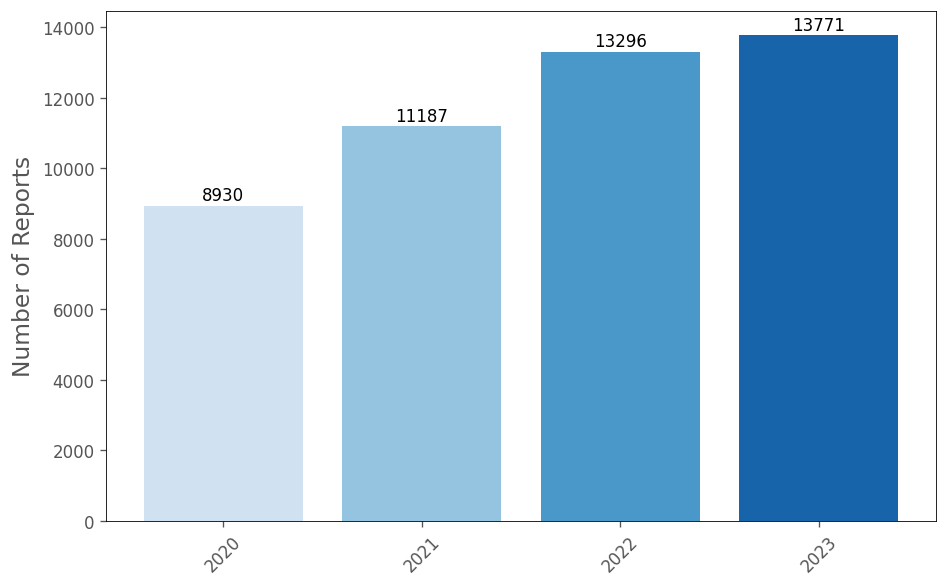

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

# Set font family
rcParams['font.family'] = 'sans-serif'

# Set style and figure resolution
plt.style.use('ggplot')
plt.figure(figsize=(8, 5), dpi=120, facecolor='white')  # Set figure background to white

# Plotting with gradient colors
bars = plt.bar(reports_per_year['Year'].astype(str), reports_per_year['No. of Reports'],
               color=sns.color_palette("Blues", len(reports_per_year)))

# Add bar labels for each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 50, int(yval), ha='center', va='bottom', fontsize=10)

# Adding labels, title, and formatting
plt.ylabel('Number of Reports', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add black border to the plot
ax = plt.gca()  # Get current axis
for spine in ax.spines.values():
    spine.set_edgecolor('black')  # Set color of border to black
    spine.set_linewidth(0.5)  # Set border width

# Set background color of axes to white
ax.set_facecolor('white')

# Display the plot
plt.tight_layout()
plt.show()



### 3.2 Adverse Event Trend over Time

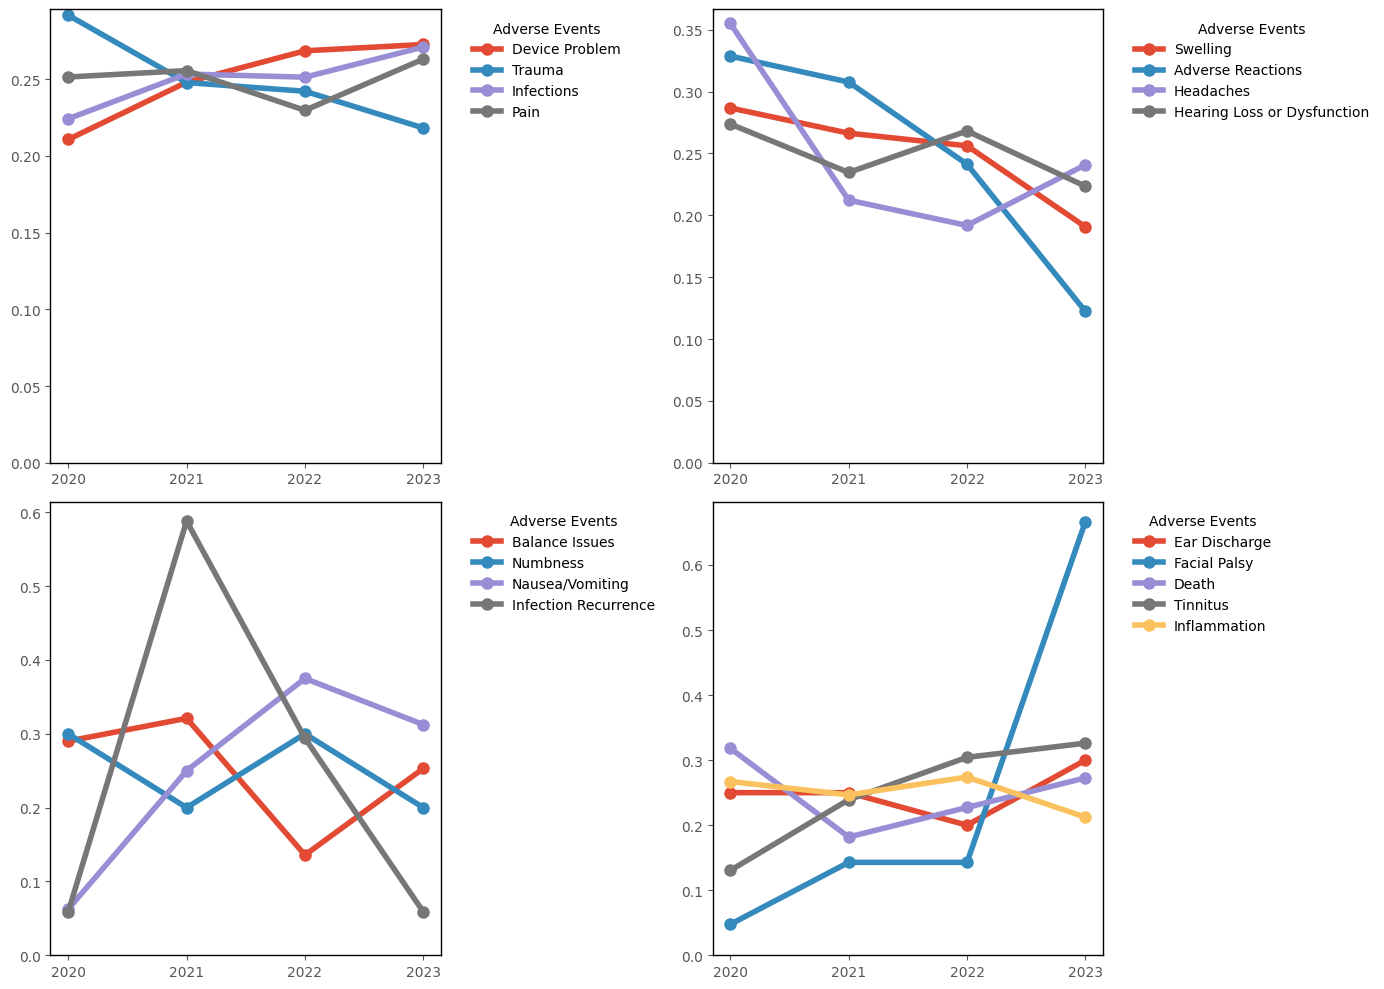

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ensuring the DATE_RECEIVED column is in datetime format
data['DATE_RECEIVED'] = pd.to_datetime(data['DATE_RECEIVED'], errors='coerce')

# extracting the year from the DATE_RECEIVED column
data['Year'] = data['DATE_RECEIVED'].dt.year

# filtering the data for the years 2020 to 2023
data_filtered = data[data['Year'].isin([2020, 2021, 2022, 2023])]

# counting the number of reports for each adverse event by year
event_year_counts = (
    data_filtered.explode('identified_events')
    .groupby(['identified_events', 'Year'])
    .size()
    .unstack(fill_value=0)
)

# total counts of reports for each adverse event across all years (2020-2023)
total_event_counts_all_years = event_year_counts.sum(axis=1)

# normalizing the event year counts by the total number of reports for each adverse event
event_year_normalized = event_year_counts.div(total_event_counts_all_years, axis=0)

# getting adverse events based on total number of reports across all years
top_9_events = total_event_counts_all_years.nlargest(9).index
bottom_8_events = total_event_counts_all_years.nsmallest(8).index

# combining top and bottom events to get groups of 4,4,4,5 events
all_events = list(top_9_events) + list(bottom_8_events)
group_1 = all_events[:4]
group_2 = all_events[4:8]
group_3 = all_events[8:12]
group_4 = all_events[12:]

# subplots for each group of events
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# function to plot a group of events
def plot_group(events, ax):
    ax.set_facecolor('white')
    for event in events:
        ax.plot(event_year_normalized.columns.astype(str), event_year_normalized.loc[event],
                marker='o', label=event, linewidth=4, markersize=8)
    ax.legend(title='Adverse Events', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False, facecolor='white', edgecolor='black')
    ax.grid(True)

    # Set the boundary (spines) around the plot
    ax.spines['top'].set_linewidth(1)
    ax.spines['top'].set_color('black')
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_linewidth(1)
    ax.spines['left'].set_color('black')
    ax.spines['right'].set_linewidth(1)
    ax.spines['right'].set_color('black')

    # Set the y-axis to start from 0
    ax.set_ylim(0, None)

    # Remove x and y axis labels
    ax.set_xlabel('')
    ax.set_ylabel('')

# plotting each group
plot_group(group_1, axes[0, 0])
plot_group(group_2, axes[0, 1])
plot_group(group_3, axes[1, 0])
plot_group(group_4, axes[1, 1])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()



# 4. Topic Modelling

Number of Topics: 5, Coherence Score: 0.6536
Number of Topics: 6, Coherence Score: 0.6212
Number of Topics: 7, Coherence Score: 0.7073
Number of Topics: 8, Coherence Score: 0.6060
Number of Topics: 9, Coherence Score: 0.6967
Number of Topics: 10, Coherence Score: 0.6895
Number of Topics: 11, Coherence Score: 0.6903
Number of Topics: 12, Coherence Score: 0.7011
Number of Topics: 13, Coherence Score: 0.7253
Number of Topics: 14, Coherence Score: 0.7165
Number of Topics: 15, Coherence Score: 0.6824
Number of Topics: 16, Coherence Score: 0.6835
Number of Topics: 17, Coherence Score: 0.6822
Number of Topics: 18, Coherence Score: 0.6361
Number of Topics: 19, Coherence Score: 0.7039
Number of Topics: 20, Coherence Score: 0.6623
Number of Topics: 21, Coherence Score: 0.6908
Number of Topics: 22, Coherence Score: 0.6644
Number of Topics: 23, Coherence Score: 0.6849
Number of Topics: 24, Coherence Score: 0.6915
Number of Topics: 25, Coherence Score: 0.6773
Number of Topics: 26, Coherence Score: 

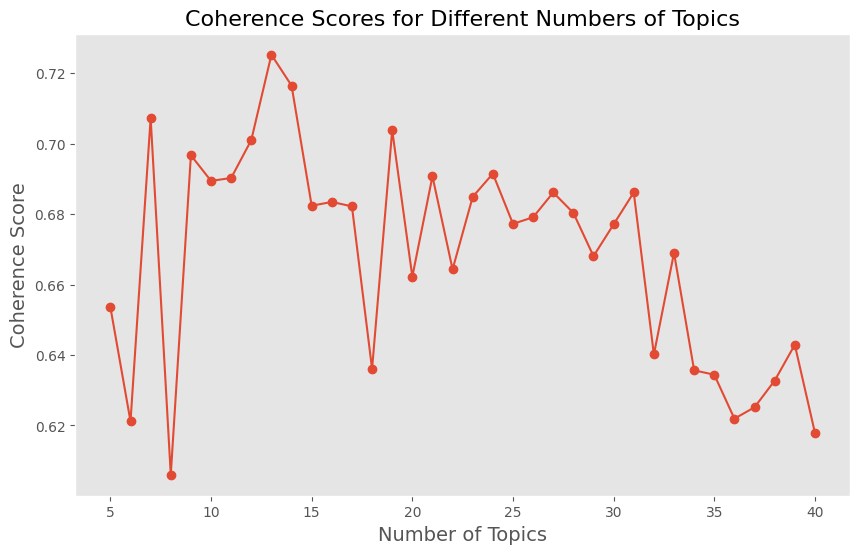

In [ ]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import matplotlib.pyplot as plt

# preprocessing function
def preprocess(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    tokens = word_tokenize(text)  # Tokenize the text
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    return tokens

# applying preprocessing
data['tokens'] = data['FOI_TEXT'].apply(preprocess)

# dictionary and corpus for Gensim
dictionary = Dictionary(data['tokens'])
corpus = [dictionary.doc2bow(text) for text in data['tokens']]

# coherence scores for a range of topics (5 to 40)
coherence_scores = {}
for num_topics in range(5, 41):
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, random_state=42)
    coherence_model = CoherenceModel(model=lda_model, texts=data['tokens'], dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores[num_topics] = coherence_score
    print(f"Number of Topics: {num_topics}, Coherence Score: {coherence_score:.4f}")

# number of topics with the highest coherence score
#optimal_num_topics = max(coherence_scores, key=coherence_scores.get)
#print(f"\nOptimal Number of Topics: {optimal_num_topics} with Coherence Score: {coherence_scores[optimal_num_topics]:.4f}")

#  coherence scores for each number of topics
plt.figure(figsize=(10, 6))
plt.plot(list(coherence_scores.keys()), list(coherence_scores.values()), marker='o')
plt.title('Coherence Scores for Different Numbers of Topics', fontsize=16)
plt.xlabel('Number of Topics', fontsize=14)
plt.ylabel('Coherence Score', fontsize=14)
plt.grid()
plt.show()



In [ ]:
optimal_num_topics = 7
#  LDA with the optimal number of topics
lda_optimal = LdaModel(corpus, num_topics=optimal_num_topics, id2word=dictionary, random_state=42)



In [ ]:
# optimal number of topics
optimal_topics = lda_optimal.print_topics(num_words=50)
print("\nOptimal Topics:")
for idx, topic in enumerate(optimal_topics):
    print(f"Topic {idx+1}: {topic}")


Optimal Topics:
Topic 1: (0, '0.054*"device" + 0.045*"electrode" + 0.044*"report" + 0.027*"final" + 0.025*"investigation" + 0.024*"damage" + 0.023*"conclusion" + 0.023*"active" + 0.023*"recipient" + 0.023*"due" + 0.021*"found" + 0.016*"problems" + 0.016*"surgery" + 0.015*"match" + 0.015*"appear" + 0.013*"failure" + 0.012*"given" + 0.012*"mechanical" + 0.011*"determined" + 0.010*"impact" + 0.010*"external" + 0.010*"mobility" + 0.010*"time" + 0.010*"consistent" + 0.009*"results" + 0.009*"according" + 0.009*"damages" + 0.008*"cochlea" + 0.008*"field" + 0.008*"minute" + 0.007*"confirmed" + 0.007*"implanted" + 0.007*"led" + 0.006*"removal" + 0.006*"fractures" + 0.006*"overload" + 0.006*"implant" + 0.006*"migration" + 0.006*"likely" + 0.006*"explantation" + 0.006*"received" + 0.006*"breakages" + 0.006*"reported" + 0.006*"attributable" + 0.006*"fatigue" + 0.006*"sterilization" + 0.006*"information" + 0.005*"wire" + 0.005*"reveal" + 0.005*"defect"')
Topic 2: (1, '0.066*"device" + 0.053*"elect

     Topic  Proportion
2  Topic 3    0.320274
4  Topic 5    0.160034
6  Topic 7    0.158408
3  Topic 4    0.122940
1  Topic 2    0.119739
0  Topic 1    0.072374
5  Topic 6    0.029887


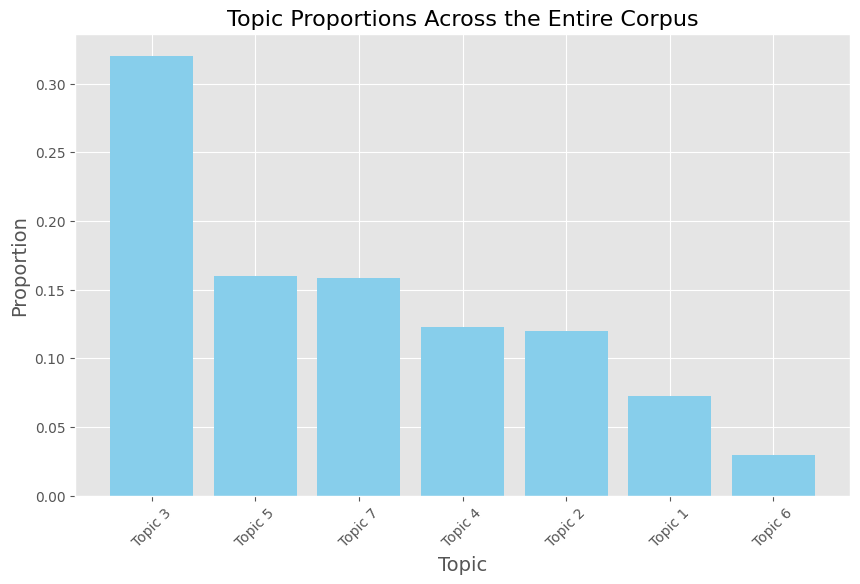

In [ ]:
# Get topic proportions for each document in the corpus
topic_proportions = [lda_optimal.get_document_topics(doc) for doc in corpus]

# Initialize a list to store the sum of topic proportions across all documents
topic_sums = [0] * optimal_num_topics

# Iterate over the topic proportions for each document
for doc_topics in topic_proportions:
    for topic_num, prop in doc_topics:
        topic_sums[topic_num] += prop

# Calculate the average proportion for each topic across the entire corpus
num_documents = len(corpus)
topic_avg_proportions = [topic_sum / num_documents for topic_sum in topic_sums]

# Convert to a DataFrame for easier visualization
topic_avg_df = pd.DataFrame({'Topic': [f'Topic {i+1}' for i in range(optimal_num_topics)], 'Proportion': topic_avg_proportions})

# Sort the topics by proportion (optional)
topic_avg_df = topic_avg_df.sort_values(by='Proportion', ascending=False)

# Display the topic proportions for the entire corpus
print(topic_avg_df)

# Visualize the topic proportions across the entire corpus using a bar plot
plt.figure(figsize=(10, 6))
plt.bar(topic_avg_df['Topic'], topic_avg_df['Proportion'], color='skyblue')
plt.title('Topic Proportions Across the Entire Corpus', fontsize=16)
plt.xlabel('Topic', fontsize=14)
plt.ylabel('Proportion', fontsize=14)
plt.xticks(rotation=45)
plt.show()


Topic 1: (0, '0.054*"device" + 0.045*"electrode" + 0.044*"report" + 0.027*"final" + 0.025*"investigation" + 0.024*"damage" + 0.023*"conclusion" + 0.023*"active" + 0.023*"recipient" + 0.023*"due" + 0.021*"found" + 0.016*"problems" + 0.016*"surgery" + 0.015*"match" + 0.015*"appear" + 0.013*"failure" + 0.012*"given" + 0.012*"mechanical" + 0.011*"determined" + 0.010*"impact" + 0.010*"external" + 0.010*"mobility" + 0.010*"time" + 0.010*"consistent" + 0.009*"results" + 0.009*"according" + 0.009*"damages" + 0.008*"cochlea" + 0.008*"field" + 0.008*"minute" + 0.007*"confirmed" + 0.007*"implanted" + 0.007*"led" + 0.006*"removal" + 0.006*"fractures" + 0.006*"overload" + 0.006*"implant" + 0.006*"migration" + 0.006*"likely" + 0.006*"explantation" + 0.006*"received" + 0.006*"breakages" + 0.006*"reported" + 0.006*"attributable" + 0.006*"fatigue" + 0.006*"sterilization" + 0.006*"information" + 0.005*"wire" + 0.005*"reveal" + 0.005*"defect"')


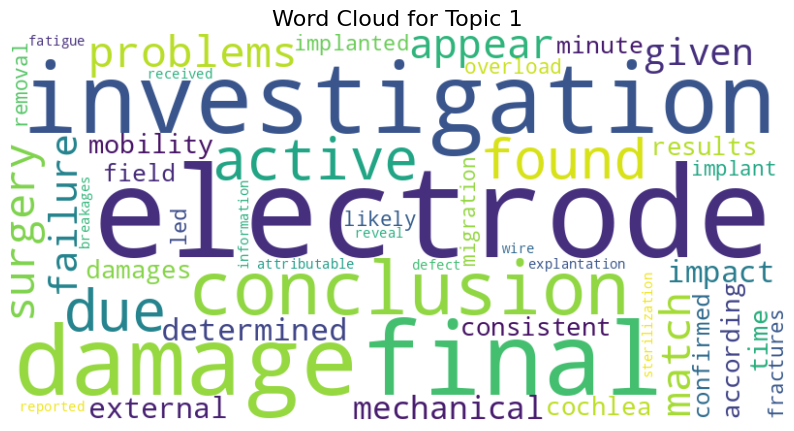

Topic 2: (1, '0.066*"device" + 0.053*"electrode" + 0.039*"performed" + 0.039*"passed" + 0.028*"advanced" + 0.028*"bionics" + 0.028*"report" + 0.028*"inspection" + 0.025*"electrical" + 0.022*"tests" + 0.017*"revealed" + 0.015*"test" + 0.014*"verified" + 0.014*"imaging" + 0.014*"system" + 0.014*"photographic" + 0.014*"occurred" + 0.014*"visual" + 0.014*"reportable" + 0.014*"final" + 0.014*"event" + 0.014*"considers" + 0.014*"investigation" + 0.014*"external" + 0.014*"closed" + 0.014*"lock" + 0.014*"believed" + 0.014*"admission" + 0.014*"fault" + 0.014*"liability" + 0.014*"product" + 0.014*"intend" + 0.014*"disclaimer" + 0.014*"defect" + 0.014*"surgery" + 0.014*"revision" + 0.014*"pocket" + 0.013*"longer" + 0.012*"distributed" + 0.012*"version" + 0.012*"mechanical" + 0.012*"ultra" + 0.012*"failure" + 0.012*"action" + 0.012*"corrective" + 0.012*"short" + 0.012*"implemented" + 0.011*"attributed" + 0.011*"prevented" + 0.011*"condition"')


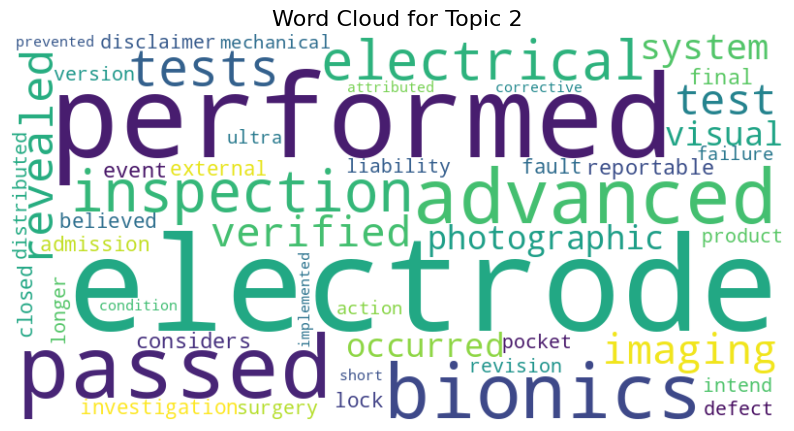

Topic 3: (2, '0.093*"advanced" + 0.093*"bionics" + 0.073*"report" + 0.063*"product" + 0.063*"defect" + 0.063*"liability" + 0.063*"admission" + 0.063*"fault" + 0.063*"intend" + 0.062*"disclaimer" + 0.040*"device" + 0.027*"recipient" + 0.021*"recipients" + 0.019*"cochlear" + 0.019*"another" + 0.019*"explanted" + 0.017*"reimplanted" + 0.008*"event" + 0.008*"reportable" + 0.008*"considers" + 0.008*"closed" + 0.008*"final" + 0.007*"investigation" + 0.007*"reportedly" + 0.004*"additional" + 0.004*"provided" + 0.004*"information" + 0.003*"details" + 0.003*"noted" + 0.002*"history" + 0.002*"record" + 0.002*"review" + 0.002*"anomalies" + 0.002*"analysis" + 0.002*"section" + 0.002*"company" + 0.002*"time" + 0.002*"completed" + 0.002*"healed" + 0.002*"b" + 0.002*"treatment" + 0.002*"use" + 0.002*"pursue" + 0.002*"surgery" + 0.002*"consent" + 0.001*"return" + 0.001*"db" + 0.001*"informed" + 0.001*"revision" + 0.001*"resolved"')


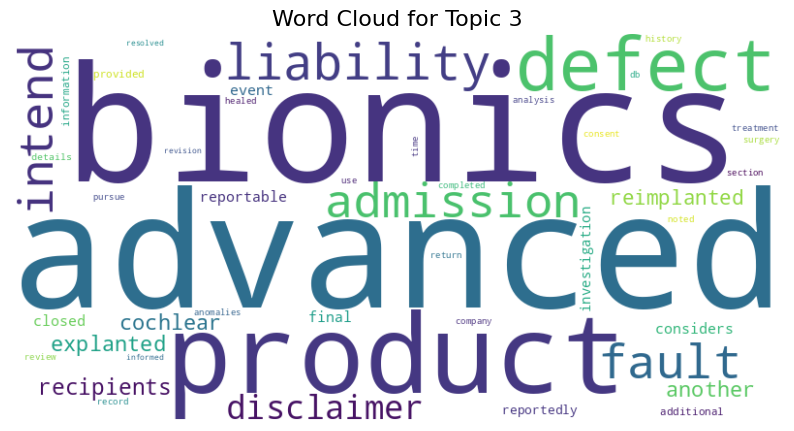

Topic 4: (3, '0.105*"device" + 0.072*"explanted" + 0.055*"information" + 0.039*"available" + 0.036*"submitted" + 0.034*"report" + 0.034*"failure" + 0.031*"analysis" + 0.030*"additional" + 0.029*"returned" + 0.027*"manufacturer" + 0.027*"evaluation" + 0.027*"follow" + 0.026*"received" + 0.020*"investigation" + 0.018*"however" + 0.017*"likely" + 0.017*"cause" + 0.016*"exact" + 0.016*"necessary" + 0.016*"root" + 0.015*"determine" + 0.015*"electrode" + 0.014*"damage" + 0.014*"active" + 0.014*"yet" + 0.011*"currently" + 0.010*"according" + 0.010*"reimplantation" + 0.010*"caused" + 0.010*"date" + 0.009*"due" + 0.009*"considered" + 0.009*"scheduled" + 0.009*"appears" + 0.008*"based" + 0.008*"mechanical" + 0.008*"would" + 0.005*"mobility" + 0.005*"minute" + 0.004*"impact" + 0.004*"suspected" + 0.004*"stress" + 0.004*"excessive" + 0.004*"might" + 0.004*"concerned" + 0.003*"possible" + 0.003*"reported" + 0.003*"external" + 0.003*"followup"')


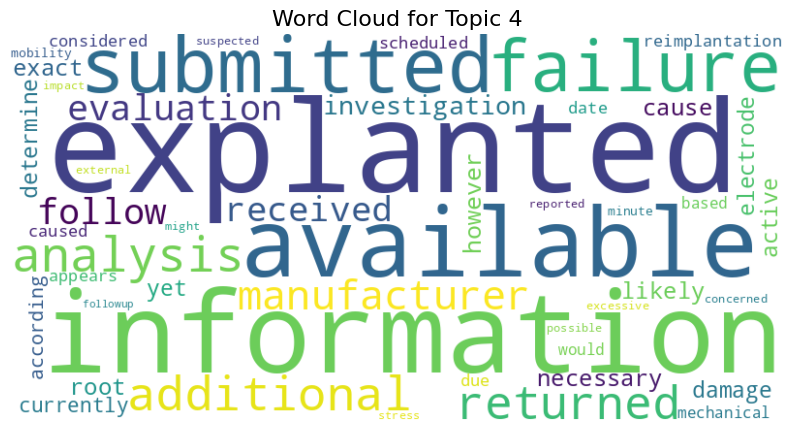

Topic 5: (4, '0.113*"recipient" + 0.065*"reportedly" + 0.043*"surgery" + 0.039*"review" + 0.036*"revision" + 0.035*"device" + 0.034*"performance" + 0.033*"issues" + 0.031*"experiencing" + 0.028*"decreased" + 0.027*"impedance" + 0.027*"recipients" + 0.026*"scheduled" + 0.020*"however" + 0.019*"experienced" + 0.018*"indicates" + 0.016*"issue" + 0.016*"made" + 0.015*"resolve" + 0.015*"programming" + 0.015*"adjustments" + 0.010*"reimplanted" + 0.008*"testing" + 0.007*"consideration" + 0.007*"explanted" + 0.007*"infection" + 0.007*"within" + 0.007*"normal" + 0.006*"sound" + 0.006*"limits" + 0.004*"external" + 0.004*"equipment" + 0.004*"prescribed" + 0.004*"despite" + 0.004*"exchanged" + 0.004*"use" + 0.004*"implant" + 0.004*"quality" + 0.004*"site" + 0.004*"antibiotics" + 0.004*"loss" + 0.003*"lock" + 0.003*"magnet" + 0.003*"pain" + 0.003*"wound" + 0.003*"skin" + 0.003*"unknown" + 0.003*"due" + 0.003*"poor" + 0.003*"revealed"')


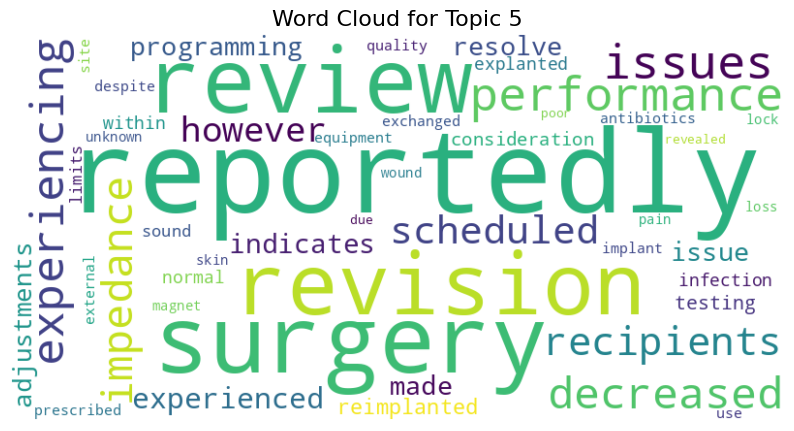

Topic 6: (5, '0.074*"test" + 0.061*"device" + 0.050*"data" + 0.029*"performed" + 0.026*"passed" + 0.021*"explanted" + 0.021*"electrical" + 0.020*"bionics" + 0.020*"advanced" + 0.020*"medical" + 0.019*"tests" + 0.019*"inspection" + 0.019*"reasons" + 0.018*"report" + 0.017*"believed" + 0.015*"revision" + 0.014*"indicated" + 0.014*"surgery" + 0.012*"lock" + 0.012*"revealed" + 0.011*"electrode" + 0.011*"analysis" + 0.011*"manufactured" + 0.011*"older" + 0.011*"configuration" + 0.011*"external" + 0.010*"imaging" + 0.010*"condition" + 0.010*"event" + 0.010*"visual" + 0.010*"system" + 0.010*"occurred" + 0.010*"photographic" + 0.010*"closed" + 0.009*"reportable" + 0.009*"considers" + 0.009*"investigation" + 0.009*"final" + 0.009*"defect" + 0.009*"product" + 0.009*"disclaimer" + 0.009*"intend" + 0.009*"liability" + 0.009*"fault" + 0.009*"admission" + 0.009*"severed" + 0.009*"prevented" + 0.009*"currently" + 0.007*"verified" + 0.006*"residual"')


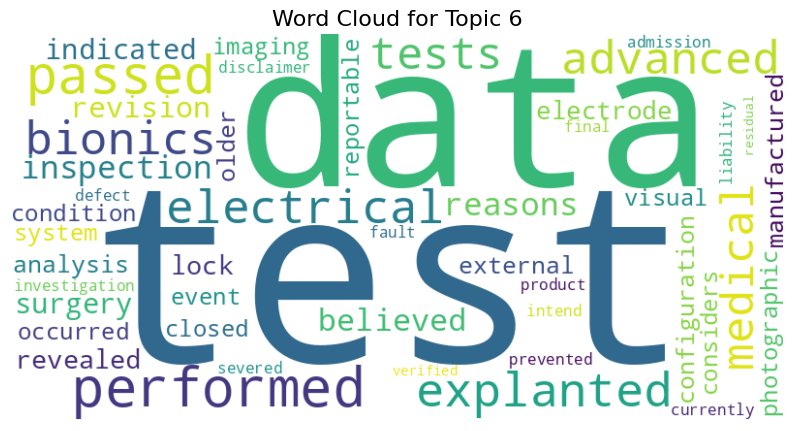

Topic 7: (6, '0.062*"user" + 0.045*"device" + 0.036*"b" + 0.035*"hearing" + 0.026*"affected" + 0.023*"reimplanted" + 0.022*"reported" + 0.021*"performance" + 0.018*"channels" + 0.015*"reimplantation" + 0.015*"implant" + 0.014*"users" + 0.013*"considered" + 0.009*"clinic" + 0.009*"situ" + 0.009*"received" + 0.009*"head" + 0.008*"trauma" + 0.008*"supplemental" + 0.008*"process" + 0.008*"obtaining" + 0.006*"information" + 0.006*"processor" + 0.006*"still" + 0.006*"seen" + 0.006*"showed" + 0.006*"measurements" + 0.006*"date" + 0.006*"hear" + 0.005*"side" + 0.005*"since" + 0.005*"sounds" + 0.005*"sound" + 0.005*"could" + 0.005*"reportedly" + 0.005*"audio" + 0.005*"yet" + 0.005*"parents" + 0.004*"testing" + 0.004*"pain" + 0.004*"noticed" + 0.004*"benefit" + 0.004*"due" + 0.004*"stopped" + 0.004*"new" + 0.004*"implantation" + 0.004*"months" + 0.004*"unknown" + 0.003*"proceed" + 0.003*"skin"')


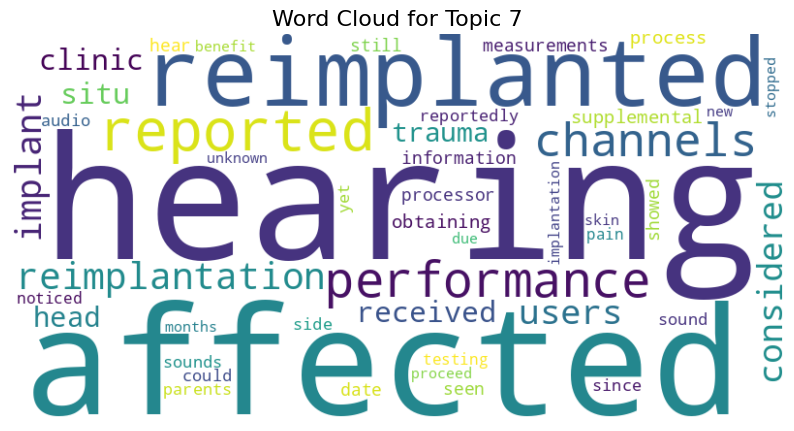

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to generate word cloud for each topic
def generate_wordcloud(topic_terms, num_words=50, remove_words=None, topic_id=None):

    word_freq = {word: weight for word, weight in topic_terms[:num_words]}

    # Remove manually specified words if any
    if remove_words:
        word_freq = {word: weight for word, weight in word_freq.items() if word not in remove_words}

    # Generate word cloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
    ).generate_from_frequencies(word_freq)

    # Plot the word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

    # Update title to include the topic number
    plt.title(f'Word Cloud for Topic {topic_id+1}', fontsize=16)
    plt.show()

# specify words to remove
remove_words = ['device', 'b','report','user', 'h', 'recipient' ]

# Generate word clouds for the optimal topics
for idx, topic in enumerate(optimal_topics):
    print(f"Topic {idx+1}: {topic}")
    # Extract the top words from the topic 50 words
    topic_terms = lda_optimal.show_topic(idx, topn=50)
    # Generate word cloud for the topic, excluding the manually specified words
    generate_wordcloud(topic_terms, num_words=50, remove_words=remove_words, topic_id=idx)


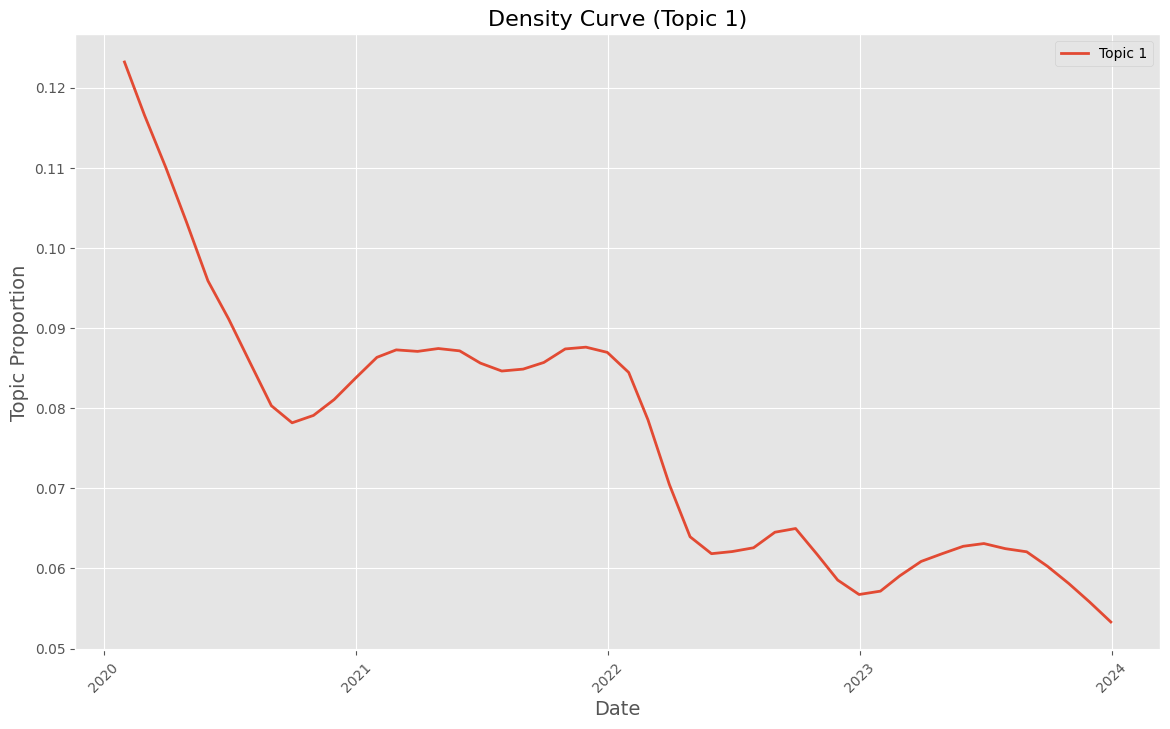

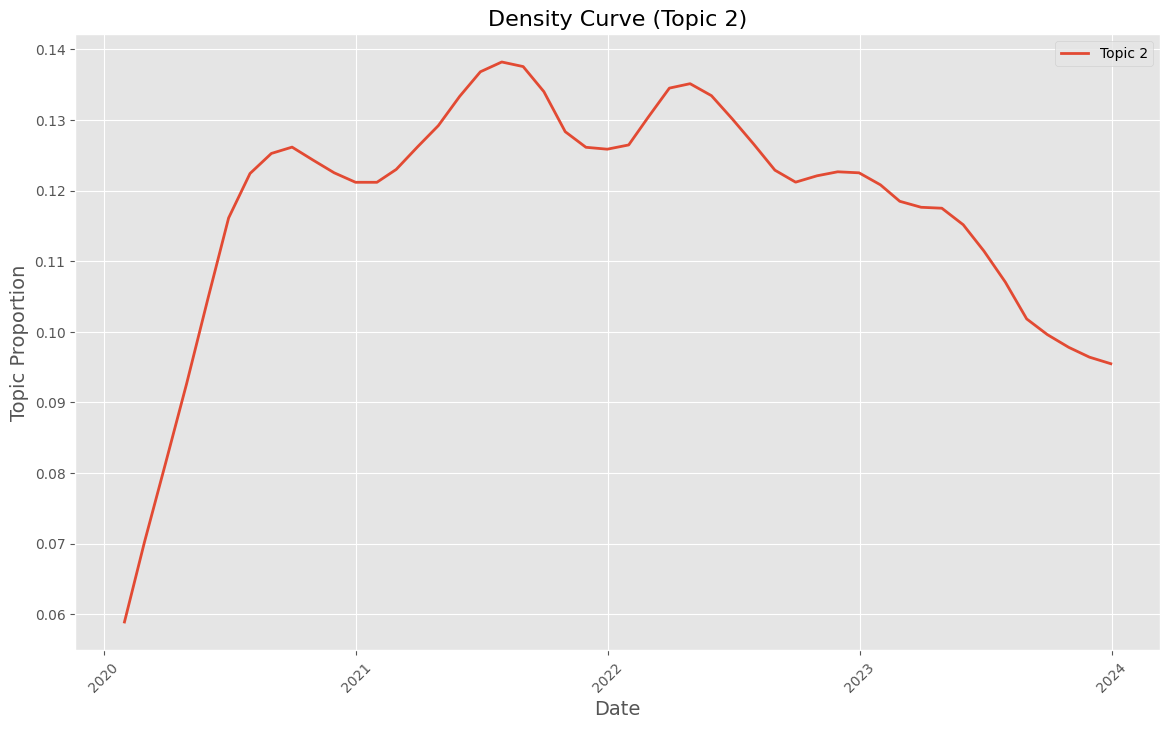

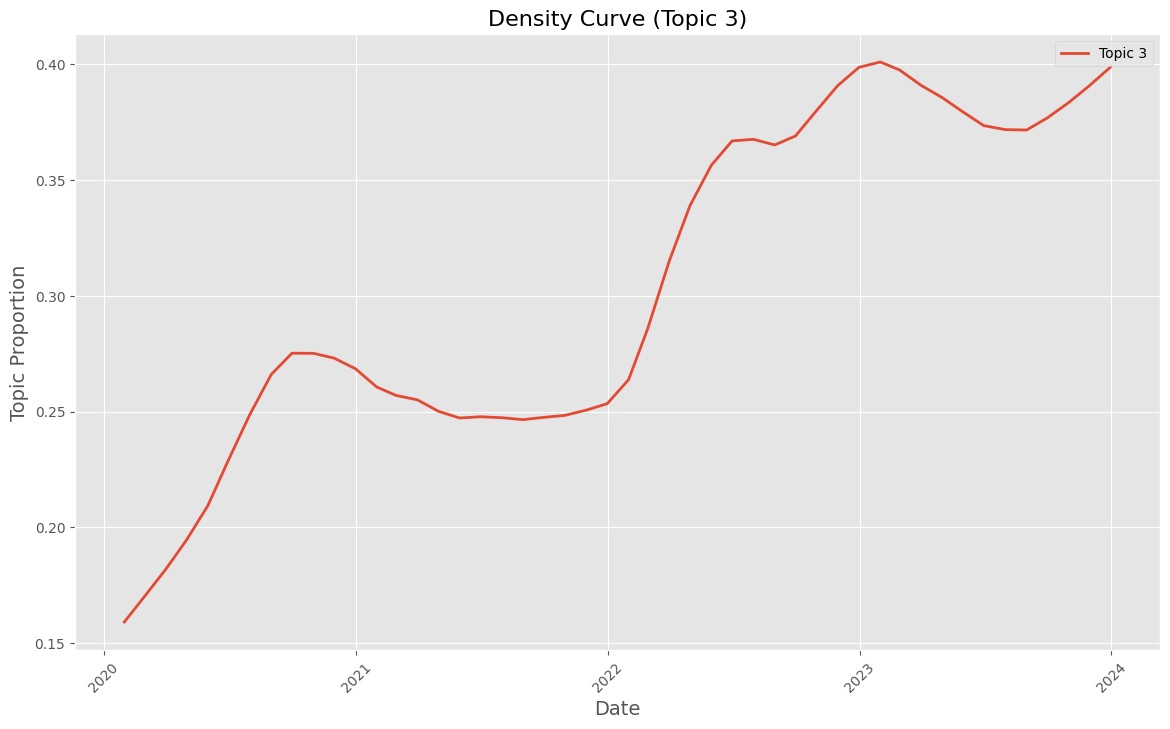

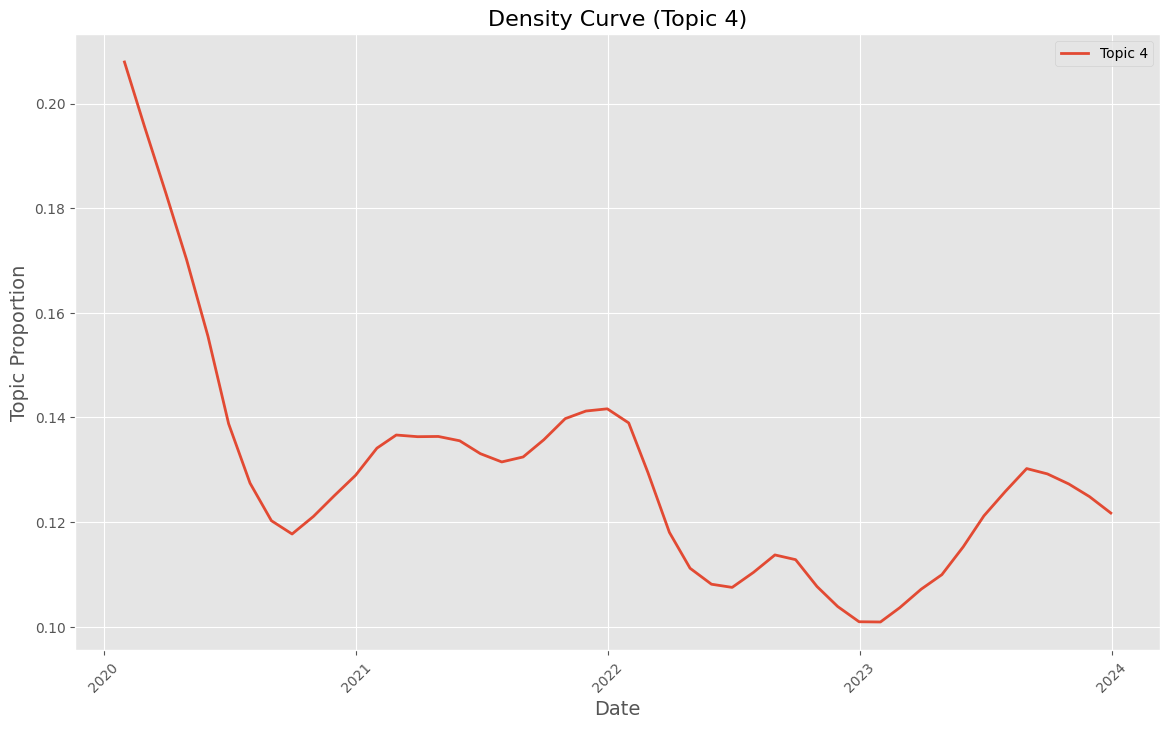

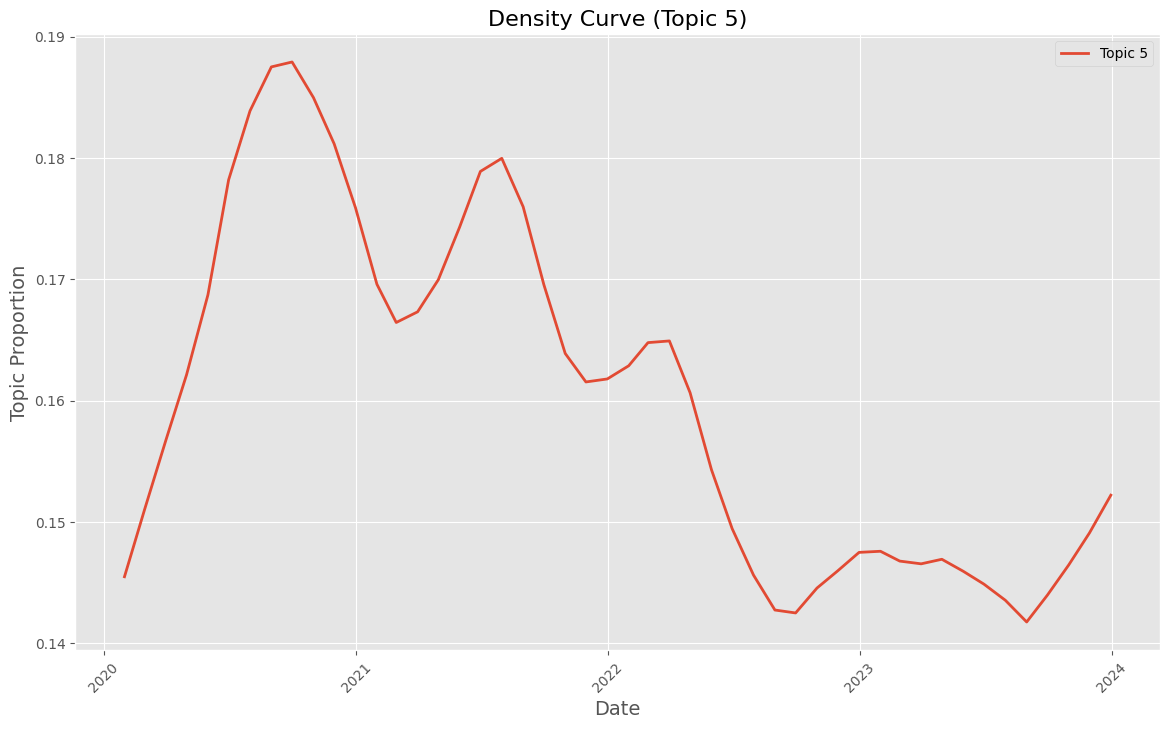

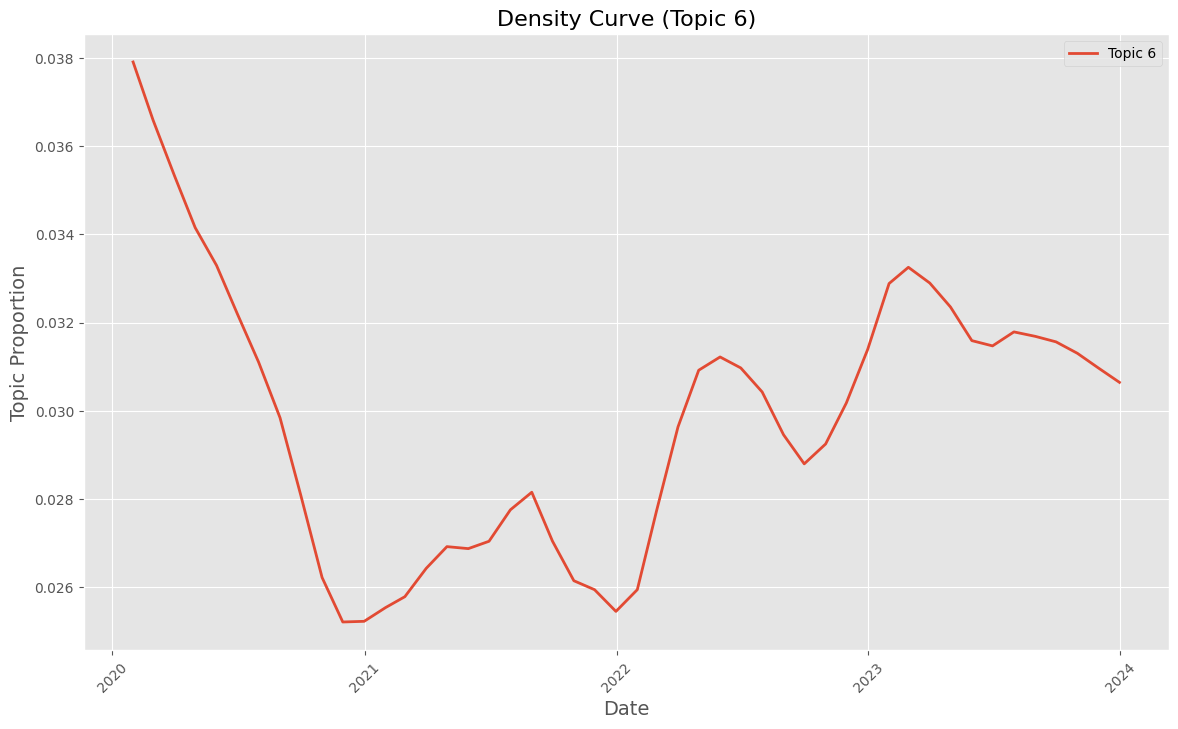

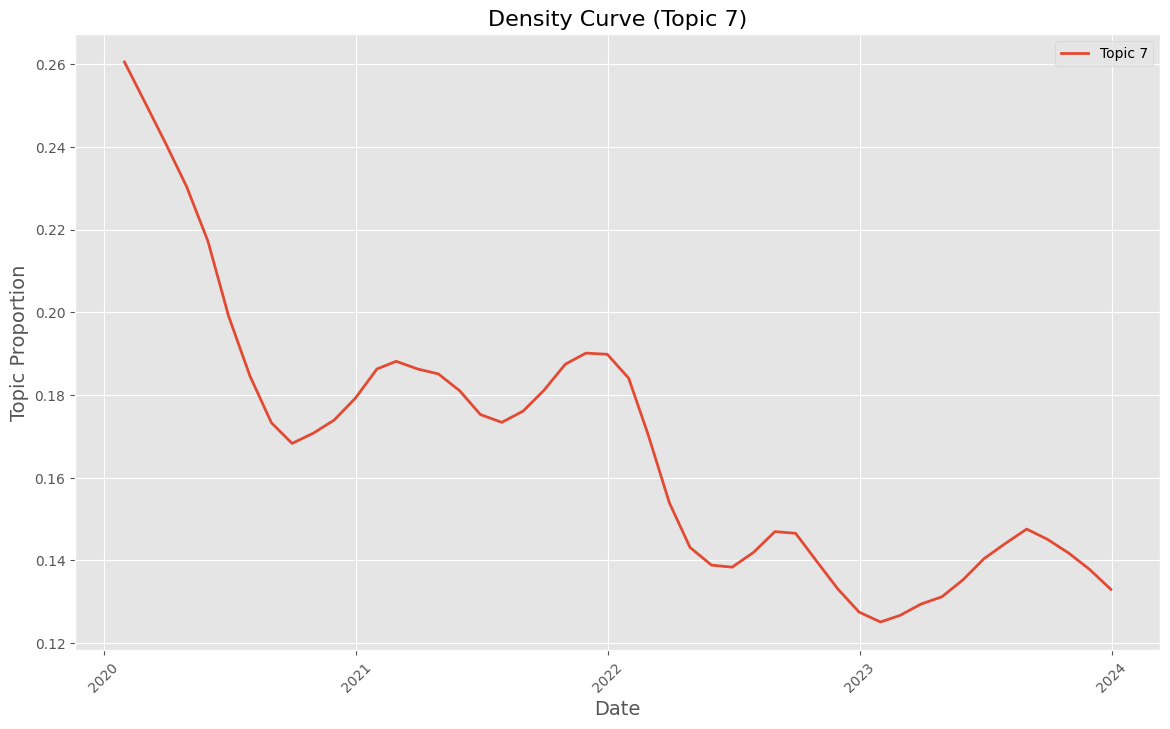

In [ ]:
import matplotlib.dates as mdates

for topic_id in range(num_topics):
    plt.figure(figsize=(14, 8))

    # Apply LOESS smoothing
    smoothed = lowess(topic_df_resampled.iloc[:, topic_id], x, frac=0.2)  # frac controls the smoothing level

    # Plot the smoothed topic density curve
    plt.plot(topic_df_resampled.index, smoothed[:, 1], label=f"Topic {topic_id+1}", linewidth=2)

    # Customize the plot
    plt.title(f'Density Curve (Topic {topic_id+1})', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Topic Proportion', fontsize=14)
    plt.legend(loc='best')
    plt.grid(True)

    # Format the x-axis to show only one tick per year
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xticks(rotation=45)
    plt.show()



# Mapping Adverse events to Topics

In [ ]:
import plotly.graph_objects as go


In [ ]:
import plotly.graph_objects as go
from collections import defaultdict


topic_adverse_event_links = {}

# loop through each topic and its keywords
for idx, topic in enumerate(optimal_topics):
    topic_words = [word.split('*')[1].strip().strip('"') for word in topic[1].split(' + ')]
    linked_events = defaultdict(int)


    for event, keywords in adverse_events_keywords.items():
        for keyword in keywords:

            if any(word in topic_words for word in keyword.split()):
                linked_events[event] += 1

    topic_adverse_event_links[f"Topic {idx+1}"] = linked_events

# list of all topics and adverse events to be used as nodes
sankey_nodes = []
for topic in topic_adverse_event_links.keys():
    sankey_nodes.append(topic)

# adding adverse events as nodes
for events in topic_adverse_event_links.values():
    for event in events.keys():
        if event not in sankey_nodes:
            sankey_nodes.append(event)

# list of sankey links
sankey_links = []

for topic, event_counts in topic_adverse_event_links.items():
    for event, count in event_counts.items():
        if count > 0:
            sankey_links.append({
                'source': sankey_nodes.index(topic),
                'target': sankey_nodes.index(event),
                'value': count
            })

# defining colors
distinct_colors = [
    "rgb(255, 0, 0)",
    "rgb(255, 165, 0)",
    "rgb(255, 255, 0)",
    "rgb(0, 128, 0)",
    "rgb(0, 0, 255)",
    "rgb(75, 0, 130)",
    "rgb(238, 130, 238)",
    "rgb(0, 255, 255)",
    "rgb(255, 99, 71)",
    "rgb(0, 0, 139)",
    "rgb(255, 105, 180)",
    "rgb(255, 69, 0)",
    "rgb(255, 20, 147)",
    "rgb(50, 205, 50)",
    "rgb(255, 215, 0)"
]

# assigning a unique color to each adverse event node
adverse_event_colors = {}
for idx, event in enumerate(sankey_nodes):
    if event.startswith("Topic") is False:
        adverse_event_colors[event] = distinct_colors[idx % len(distinct_colors)]

# setting color
node_colors = []
for node in sankey_nodes:
    if node.startswith("Topic"):
        node_colors.append("black")
    else:
        node_colors.append(adverse_event_colors.get(node, "grey"))

# creating  Sankey diagram
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=sankey_nodes,
        color=node_colors
    ),
    link=dict(
        source=[link['source'] for link in sankey_links],
        target=[link['target'] for link in sankey_links],
        value=[link['value'] for link in sankey_links],
        color=[adverse_event_colors[sankey_nodes[link['target']]] for link in sankey_links]
    )
))

# updating the layout for the Sankey diagram
fig.update_layout(
    title_text="Topic-Adverse Event Transition Densities",
    font_size=10,
    showlegend=True
)

# displaying the Sankey diagram
fig.show()

